In [1]:
!pip install yfinance

In [91]:
# Imports 
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller



In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


def check_stationarity(series):
    adf_result = adfuller(series)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

def window_generator(data, feature_columns, target_column, input_size, output_size, stride):
    X = []
    y = []

    data = data.sort_index()
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(data[feature_columns])
    scaled_target = target_scaler.fit_transform(data[target_column])
    for start in range(0, len(data) - input_size - output_size + 1, stride):
        end_input = start + input_size
        end_output = end_input + output_size

        X.append(data[feature_columns].iloc[start:end_input].values)
        y.append(data[target_column].iloc[end_input:end_output].values)

    return np.array(X), np.array(y), feature_scaler, target_scaler


In [3]:
with open("tickers.txt", "r") as file:
    tickers = [line.strip() for line in file]

output_file = "sp500_data.csv"
with open(output_file, "w") as f:
    f.write("Ticker,Date, Volume,Price_Change\n")

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        stock = yf.Ticker(ticker)
        index = stock.history(start="2010-01-01", end="2020-01-01")

        if index.empty:
            print(f"No data for {ticker}. Skipping...")
            continue

        expected_days = 252 * 9  # 10 years of trading data
        if len(index) < expected_days:
            print(f"Incomplete data for {ticker} ({len(index)} days). Skipping...")
            continue

        index['Price_Change'] = index['Close'].pct_change()

        index.reset_index(inplace=True)
        index['Ticker'] = ticker
        index[['Ticker', 'Date', 'Volume', 'Price_Change']].to_csv(
            output_file, mode='a', header=False, index=False
        )

    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
print(f"Data collection complete! Saved to {output_file}.")

Fetching data for EQIX...
Fetching data for STLD...
Fetching data for GPC...
Fetching data for BKNG...
Fetching data for CSX...
Fetching data for AON...
Fetching data for BLK...
Fetching data for TJX...
Fetching data for IRM...
Fetching data for ELV...
Fetching data for ANET...
Incomplete data for ANET (1403 days). Skipping...
Fetching data for LVS...
Fetching data for PCG...
Fetching data for FAST...
Fetching data for GLW...
Fetching data for CNC...
Fetching data for TPR...
Fetching data for CL...
Fetching data for PWR...
Fetching data for FDX...
Fetching data for ROST...
Fetching data for WDC...
Fetching data for V...
Fetching data for AMD...
Fetching data for PM...
Fetching data for NVR...
Fetching data for J...
Fetching data for KDP...
Fetching data for TSLA...
Fetching data for PHM...
Fetching data for HD...
Fetching data for KEYS...
Incomplete data for KEYS (1309 days). Skipping...
Fetching data for LW...
Incomplete data for LW (789 days). Skipping...
Fetching data for RCL...
Fet

In [4]:
clean_data = pd.read_csv("sp500_data.csv")
print(clean_data.shape)
missing_summary = clean_data.isnull().sum()
print(missing_summary[missing_summary > 0])

# Get unique tickers from the 'Ticker' column
unique_tickers = clean_data['Ticker'].unique()

# Count the number of unique tickers
print(f"Number of unique tickers: {len(unique_tickers)}")

#X = clean_data.drop(columns=['Price_Change'])
#y = clean_data['Price_Change']
#print(X.shape, y.shape)
#print(X.head())
#print(y.head())

(1108610, 4)
Price_Change    441
dtype: int64
Number of unique tickers: 441


In [5]:

# Download data
data = yf.download("^GSPC", start="2010-01-01", end="2020-01-01")

# Select relevant columns
index_data = data[["Volume", "Close"]]

# Calculate Price Change
index_data['Price_Change'] = index_data['Close'].pct_change()

# Reset the MultiIndex columns
index_data.columns = ['Volume', 'Close', 'Price_Change']

# Check for rows with NaN values
print("Rows with NaN values:")
print(index_data[index_data.isna().any(axis=1)])

# Drop rows with NaN values
index_data = index_data.dropna(how='any')  # Drops rows where any column has NaN

# Save cleaned data to CSV
index_data.to_csv("sp500_index_volume.csv", mode='w', header=True, index=True)

# Display the cleaned data
print("Cleaned Data:")
print(index_data.head())

[*********************100%***********************]  1 of 1 completed

Rows with NaN values:
                Volume       Close  Price_Change
Date                                            
2010-01-04  3991400000  1132.98999           NaN
Cleaned Data:
                Volume        Close  Price_Change
Date                                             
2010-01-05  2491020000  1136.520020      0.003116
2010-01-06  4972660000  1137.140015      0.000546
2010-01-07  5270680000  1141.689941      0.004001
2010-01-08  4389590000  1144.979980      0.002882
2010-01-11  4255780000  1146.979980      0.001747



/var/folders/0p/n71jz5_54ns2wr18_8vqx9040000gn/T/ipykernel_27681/315180136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_data['Price_Change'] = index_data['Close'].pct_change()


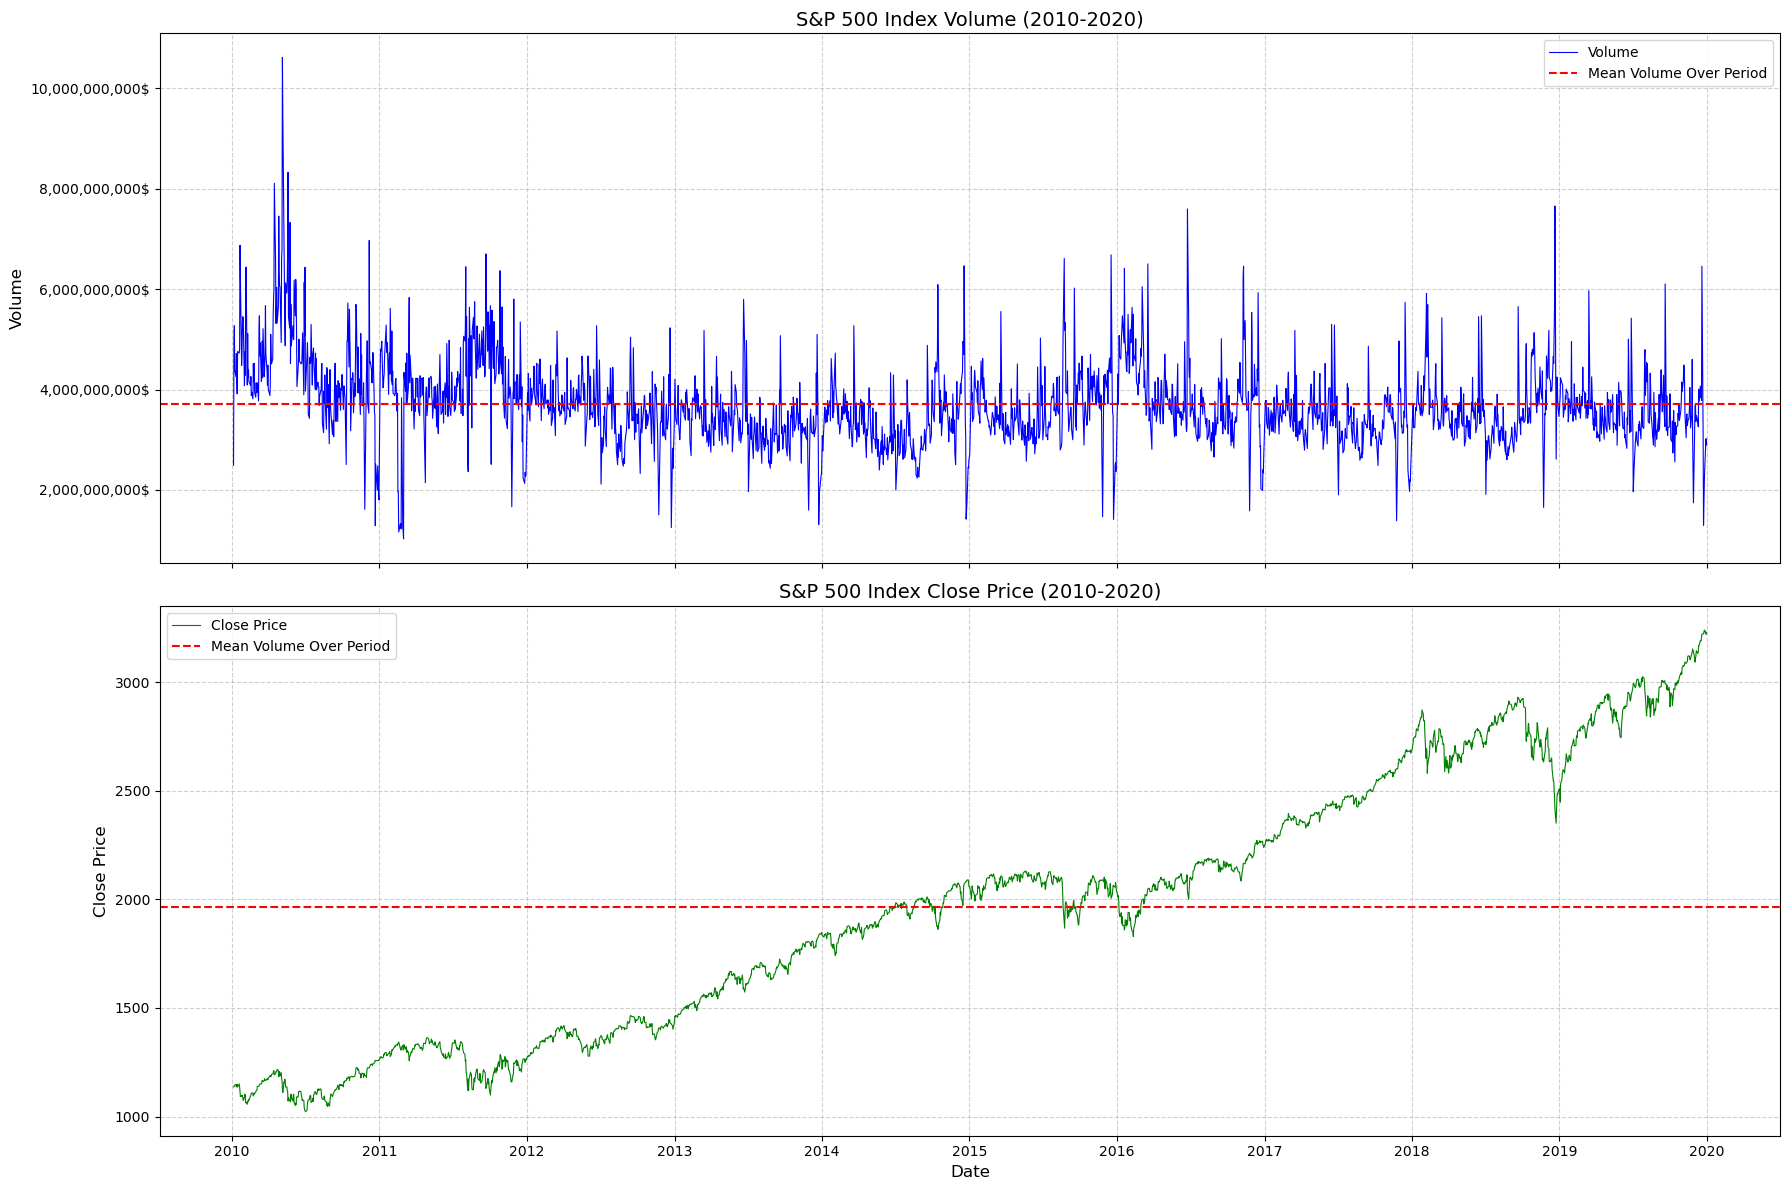

In [6]:
from matplotlib.ticker import FuncFormatter


def format_large_values(x, pos):
    return f'{int(x):,}$'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

ax1.plot(index_data.index, index_data['Volume'].values, label="Volume", linewidth=0.8, color='blue')
ax1.set_title("S&P 500 Index Volume (2010-2020)", fontsize=14)
ax1.set_ylabel("Volume", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)
ax1.yaxis.set_major_formatter(FuncFormatter(format_large_values))
ax1.axhline(y=index_data['Volume'].values.mean(), color='red', linestyle='--', label="Mean Volume Over Period")
ax1.legend()

ax2.plot(index_data.index, index_data['Close'].values, label="Close Price", linewidth=0.8, color='green')
ax2.axhline(y=index_data['Close'].values.mean(), color='red', linestyle='--', label="Mean Volume Over Period")
ax2.set_title("S&P 500 Index Close Price (2010-2020)", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Close Price", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

In [7]:
index_data.shape, clean_data.shape

((2515, 3), (1108610, 4))

In [39]:
ticker_data = clean_data.pivot(index='Date', columns='Ticker', values=[' Volume', 'Price_Change'])

ticker_data.columns = ['_'.join(col).strip() for col in ticker_data.columns.values]

ticker_data = ticker_data.reset_index()

ticker_data['Date'] = pd.to_datetime(ticker_data['Date'], errors='coerce')  # Handle malformed dates gracefully


ticker_data = ticker_data.set_index('Date')
ticker_data.head(2)

ticker_data = ticker_data[~ticker_data.index.isna()]

ticker_data.to_csv("ticker_data.csv")

ticker_data.index = pd.to_datetime(ticker_data.index, utc=True)
ticker_data.index = ticker_data.index.date

ticker_data

/var/folders/0p/n71jz5_54ns2wr18_8vqx9040000gn/T/ipykernel_27681/4095882232.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  ticker_data['Date'] = pd.to_datetime(ticker_data['Date'], errors='coerce')  # Handle malformed dates gracefully


,Volume_A,Volume_AAL,Volume_AAPL,Volume_ABT,Volume_ACGL,Volume_ACN,Volume_ADBE,Volume_ADI,Volume_ADM,Volume_ADP,...,Price_Change_WTW,Price_Change_WY,Price_Change_WYNN,Price_Change_XEL,Price_Change_XOM,Price_Change_XRAY,Price_Change_YUM,Price_Change_ZBH,Price_Change_ZBRA,Price_Change_ZION
2010-01-04,3815561.0,9837300.0,493729600.0,10829095.0,4813200.0,3650100.0,4710200.0,2102700.0,3472500.0,3930120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,4186031.0,25212000.0,601904800.0,10562109.0,3807000.0,2613000.0,7108800.0,2040100.0,3458700.0,3252415.0,...,-0.002241,0.021228,0.060819,-0.011860,0.003905,-0.011887,-0.003420,0.031656,-0.001744,0.035259
2010-01-06,3243779.0,16597900.0,552160000.0,11401417.0,3156300.0,5772100.0,5336400.0,2105000.0,3745800.0,3111406.0,...,0.016099,-0.011057,-0.013117,0.001920,0.008643,0.006588,-0.007149,-0.000323,-0.007687,0.086957
2010-01-07,3095172.0,14033400.0,477131200.0,12857232.0,3327300.0,4022900.0,5576700.0,2033400.0,7232100.0,2513317.0,...,-0.002947,-0.004472,0.021357,-0.004312,-0.003142,0.013090,-0.000288,0.022940,-0.025000,0.112000
2010-01-08,3733918.0,12760000.0,447610800.0,12148604.0,2155500.0,5069700.0,5429200.0,2393100.0,6264700.0,2310462.0,...,-0.001109,-0.009210,-0.007165,0.000481,-0.004012,0.000000,0.000288,-0.021004,-0.003250,-0.016187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,271900.0,2373600.0,48478800.0,1067700.0,221000.0,998500.0,1066400.0,487800.0,708300.0,350200.0,...,0.002034,-0.009622,-0.005634,0.003913,-0.003841,0.000524,0.005210,-0.002446,-0.009348,0.003701
2019-12-26,649100.0,4746500.0,93121200.0,2033100.0,410100.0,1059800.0,1055100.0,912600.0,985100.0,1713700.0,...,0.000148,0.004690,0.010757,-0.001114,0.001571,-0.010156,0.014552,-0.002191,0.000354,0.002523
2019-12-27,767700.0,8416500.0,146266000.0,2508100.0,775800.0,1292200.0,1229800.0,1360900.0,1355000.0,821400.0,...,-0.001287,-0.000333,-0.008018,0.005256,-0.003422,0.005484,0.001081,-0.001930,0.006210,-0.003097
2019-12-30,742800.0,4940300.0,144114400.0,2706100.0,837200.0,1193900.0,1896700.0,1107300.0,1375600.0,867100.0,...,0.002337,-0.001668,-0.003076,0.002693,-0.005867,-0.007741,-0.012365,-0.008399,-0.007383,0.005243


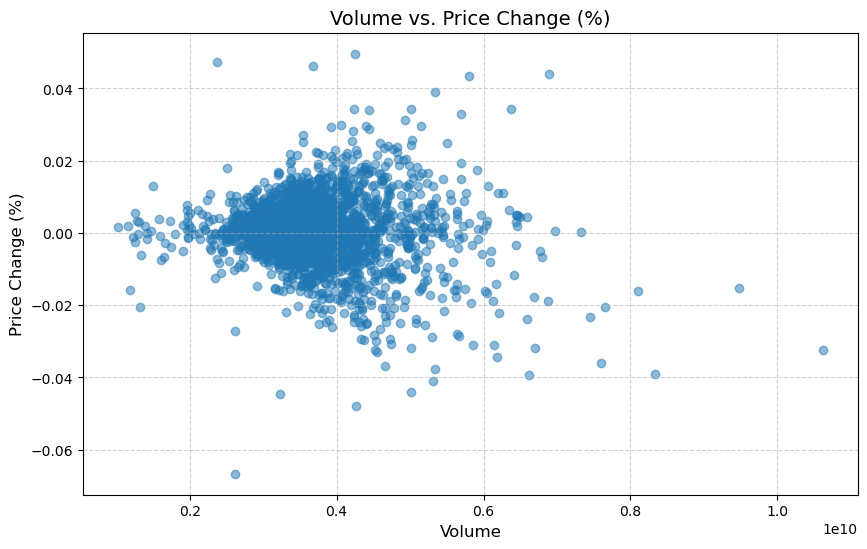

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(index_data["Volume"], index_data["Price_Change"], alpha=0.5)
plt.title("Volume vs. Price Change (%)", fontsize=14)
plt.xlabel("Volume", fontsize=12)
plt.ylabel("Price Change (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

High Volume and High Price Change:

Outliers on the top-right or bottom-right of the graph (large volume with significant price changes) could indicate market-moving events.
Market Stability:

The concentration of points near the origin suggests that most days see stable prices and moderate trading activity.
Event-Driven Volatility:

The outliers (large price changes or unusually high volumes) may help you identify event-driven periods that warrant further investigation.


In [10]:
index_datas = pd.read_csv('sp500_index_volume.csv')
        
check_stationarity(index_datas['Volume'].values)
check_stationarity(index_datas['Price_Change'].values)


ADF Statistic: -5.342899295293488
p-value: 4.4596920599956524e-06
The series is stationary.
ADF Statistic: -11.461060185389677
p-value: 5.553316149027219e-21
The series is stationary.


In [82]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np



In [83]:
X,y = window_generator(ticker_data,['Volume_AAPL'],['Price_Change_AAPL'],60,20,1)

In [84]:
X.shape, y.shape

((813, 60, 1), (813, 20, 1))

In [85]:
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    Input(shape = (60, 1)),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),    
    Dense(20, activation='linear')  # Match the output shape (20, 1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,972 (117.08 KB)

 Trainable params: 29,972 (117.08 KB)

 Non-trainable params: 0 (0.00 B)

None


In [92]:
# Train the model
history = model.fit(
    X, y,
    epochs=300,           # Number of training epochs
    batch_size=32,       # Batch size
    validation_split=0.2 # Use 20% of the data for validation
)

Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 71088955392.0000 - mae: 24496.1250 - val_loss: 0.0120 - val_mae: 0.0963
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6468681216.0000 - mae: 10056.3174 - val_loss: 0.0121 - val_mae: 0.0964
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 11174148096.0000 - mae: 15868.2246 - val_loss: 0.0121 - val_mae: 0.0965
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 22125103104.0000 - mae: 15179.6768 - val_loss: 0.0121 - val_mae: 0.0965
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9657989120.0000 - mae: 12083.4199 - val_loss: 0.0121 - val_mae: 0.0966
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 14040596480.0000 - mae: 13950.3320 - val_loss: 0.0121 - val_mae: 0.0967
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3252115712.0000 - mae: 5564.3843 - val_loss: 0.0121 - val_mae: 0.0968
Epoch 8/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6981493760.0000 - ma

KeyboardInterrupt: 

In [ ]:
print("Input shape (X):", X.shape)  # Expected: (813, 60, 1)
print("Target shape (y):", y.shape) # Expected: (813, 20, 1)

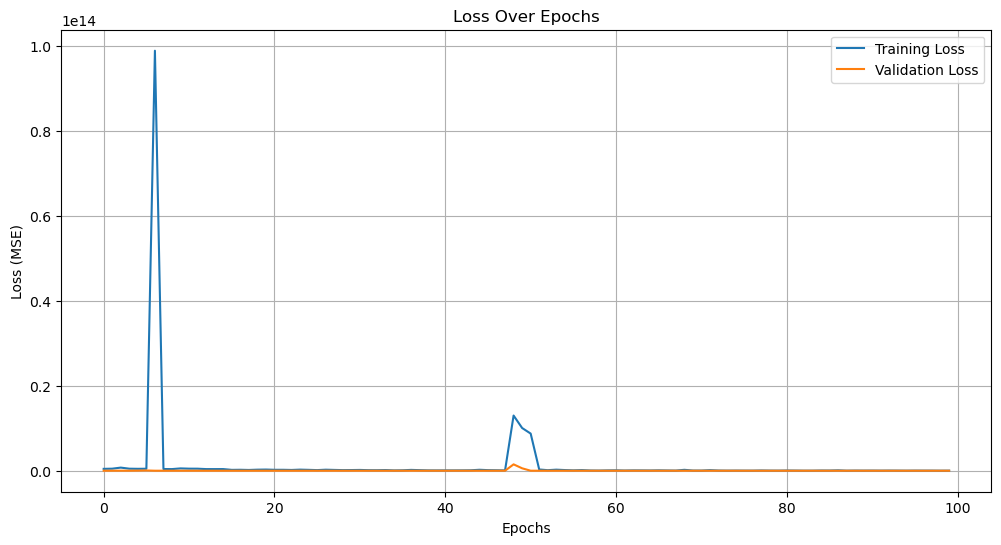

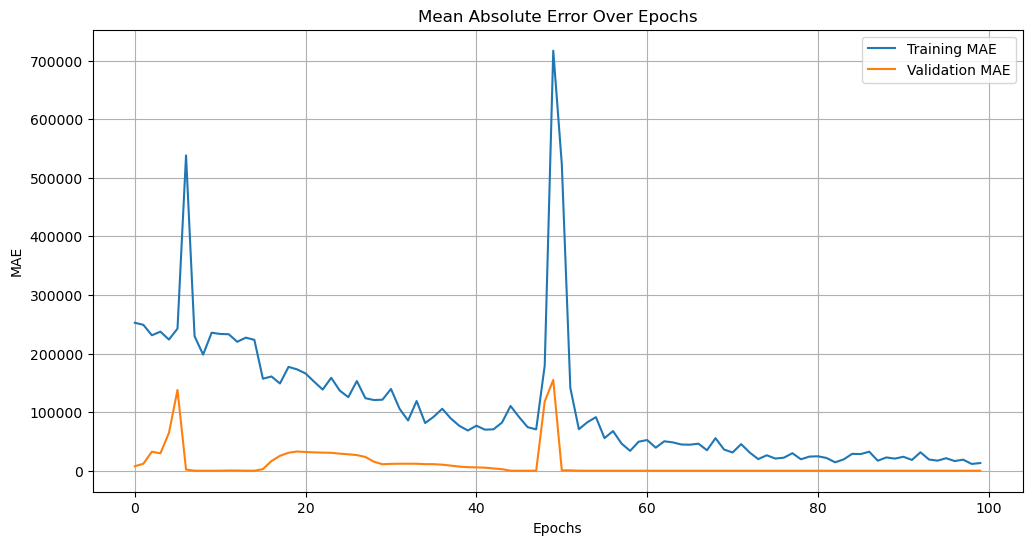

In [90]:
plot_training_history(history)